# Introduction
Author:  Miguel Angel González Arias

05, March, 2023

This notebook is part of the application to the vacant of "Técnico Académico de Tiempo completo con especialidad en bioinformática en el Instituto de Biología (UNAM)".

**By default, google colab only gives 2 CPU-cores, 12 GB of RAM and 105 GB of storage. So, i'm limited by this resources to do this analysis.**


This notebook is divided in two parts that attempt to reproduce some of the findings of two different publications about the topic in question.
1. Phylogenetics: contain the code needeed to download the protein sequences using web scrapping and clasical phylogeneitics procedures.
  - Text Minning: shows how to use the metadata of the original publication in order to process and download the protein sequences
  - Data analysis: shows the classical procedure to build a phylogenetic tree and creare the annotation files used by iTOL to vizualize the trees.
  
The main results in this section is the reproduction of the tree in the [Figure 1G](https://www.nature.com/articles/s41586-022-04741-x/figures/1).

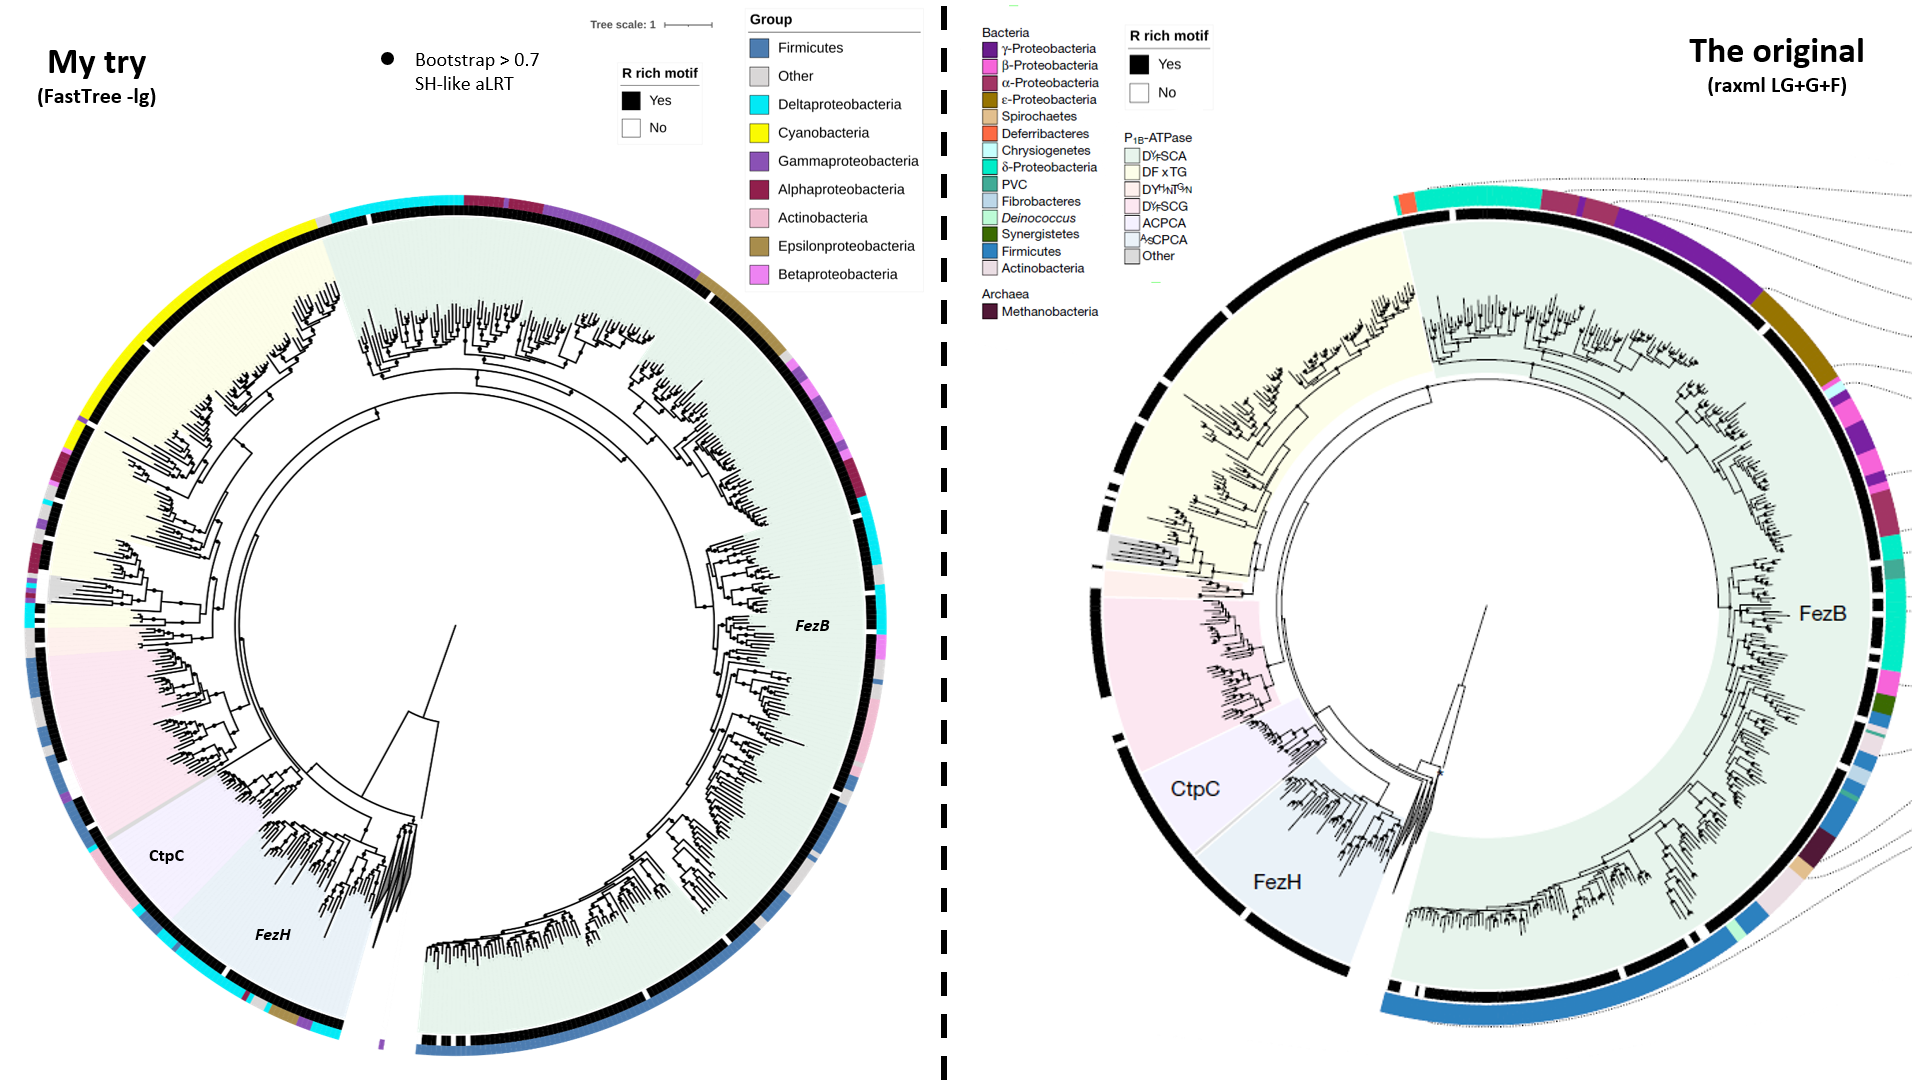

2. Ancestral sequence reconstruction: shows how to use heuristics in order to reconstruct the amino acid sequences in the nodes of the phylogenetic tree of hemoglobins using TimeTree.

The main result in this section is the structural prediction of various ancestral sequences, showing that the monomeric ancestor of hemoglobins is not capable of forming protein complexes like the posterior ancestors, like the ancestor of hemoglobin alpha and the ancestor of beta.


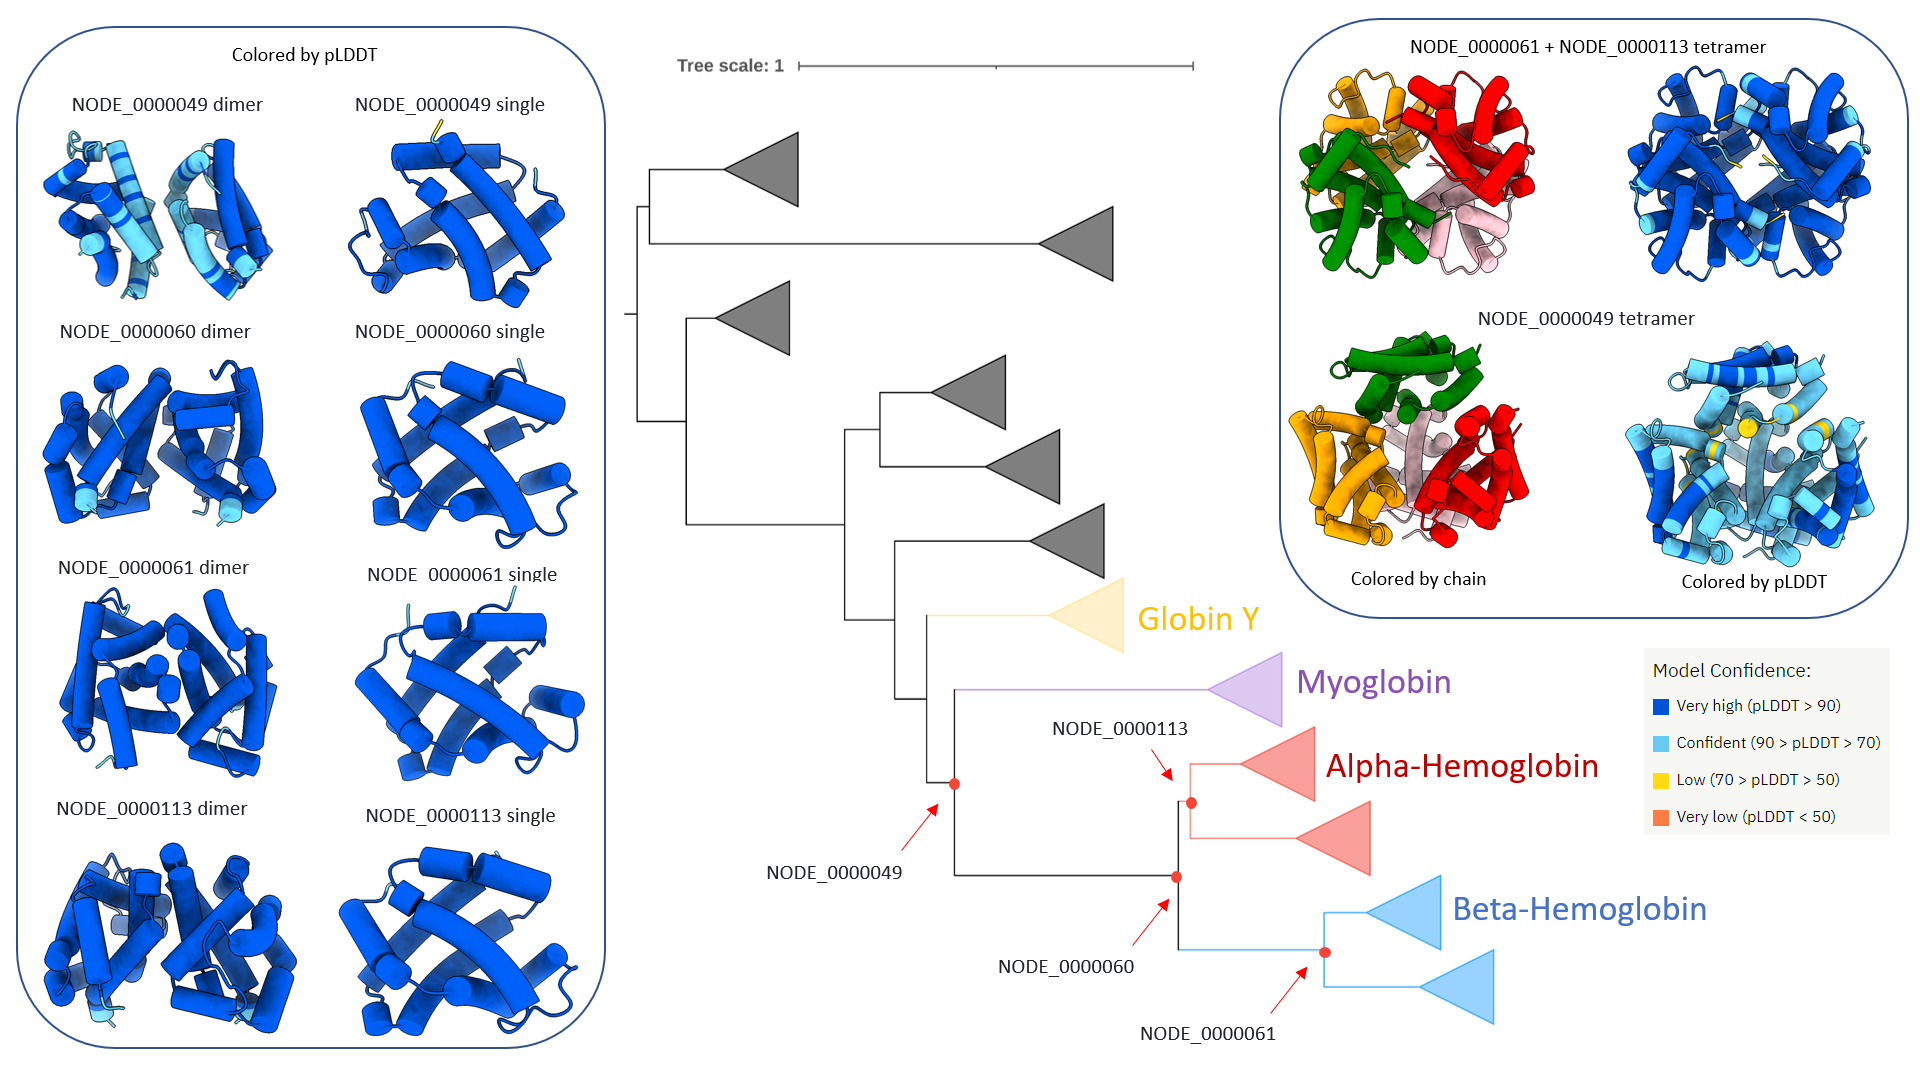



# Phylogenetics

In this section i take the data from the paper [Distinct gene clusters drive formation of ferrosome organelles in bacteria (Nature, 2022)](https://www.nature.com/articles/s41586-022-04741-x#Sec20), where the authors find an interesting organelle called "ferrosome" that is responsable for the storage of iron and that is assembled by various proteins, but the main proteins are the set of _fez proteins_.

The authors use the [JGI-IMG/M databse](https://img.jgi.doe.gov/cgi-bin/m/main.cgi) as data source.   

## Text minning

In [ ]:
# import libs
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [ ]:
# download the supplementary table 1 that contain the data that we need
# https://www.nature.com/articles/s41586-022-04741-x#Sec20
! wget -nv https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04741-x/MediaObjects/41586_2022_4741_MOESM2_ESM.xlsx

# rename it
! mv 41586_2022_4741_MOESM2_ESM.xlsx sup_tab1.xlsx

# read it without the first row and the last 5
# this is because the authors include footnotes
df = pd.read_excel("sup_tab1.xlsx", header=1, skipfooter=5)

# rename columns for simplicity
df = df.rename(columns=
               {"IMG Gene ID": "gene_id",
                "Phylum": "phylum",
                "Genome ID": "genome_id",
                "Genome Name": "gene_name",
                "Locus Tag": "locus_tag",
                "P1B-ATPase Colora": "p1b_atpase_color",
                "TM4/6b": "TM4_6",
                "TM6/8c": "TM6_8",
                "R-rich Motif d": "R_rich_motif"
                })
df

2023-02-24 13:50:28 URL:https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04741-x/MediaObjects/41586_2022_4741_MOESM2_ESM.xlsx [68439/68439] -> "41586_2022_4741_MOESM2_ESM.xlsx" [1]


gene_id                 phylum   genome_id  \
0     637124597    Deltaproteobacteria   637000096   
1     637456760  Epsilonproteobacteria   637000341   
2     637475465    Alphaproteobacteria   637000239   
3     637607529     Betaproteobacteria   637000012   
4     637781355    Deltaproteobacteria   637000095   
..          ...                    ...         ...   
628  2738928484    Alphaproteobacteria  2738541314   
629  2739817910            Chloroflexi  2739367764   
630  2745711085         Actinobacteria  2744054798   
631  2754359878            Chloroflexi  2751186035   
632  2755618021    Alphaproteobacteria  2754412603   

                                gene_name         locus_tag p1b_atpase_color  \
0    Desulfovibrio vulgaris Hildenborough           DVU3332          #E7F4EC   
1         Wolinella succinogenes DSM 1740            WS1571          #E7F4EC   
2       Rhodopseudomonas palustris CGA009           RPA2333          #E7F4EC   
3             Aromatoleum aromaticum EbN1            ebA609          #E7F4EC   
4            Desulfovibrio alaskensis G20          Dde_0495          #E7F4EC   
..                                    ...               ...              ...   
628       Rhizobium daejeonense DSM 17795   Ga0196644_11272          #FFFFFF   
629         Unclassified Anaerolineae GB5      PROKKA_00789          #FFFFFF   
630         Cutibacterium avidum HL307PV1   Ga0133096_14834          #FFFFFF   
631  Candidatus Chloroploca asiatica B7-9  Ga0213408_105212          #FFFFFF   
632                         Bosea sp. 124    Ga0213554_0932          #FFFFFF   

       TM4_6  TM6_8  R_rich_motif  
0    DYSCAIR  HNLTT          n/ae  
1    DYSCALK  HNGTT  HATSKRVRYSFC  
2    DYSCALK  HNGTT  HRLPGRIRLRYQ  
3    DYSCALK  HNGST  HRTRGRARFRYR  
4    DYSCAIK  HNAST  HEIPGRIRLRSR  
..       ...    ...           ...  
628  TSPAELG  HLGPD           NaN  
629  AGACGIA  HVASE           NaN  
630  AGACGVA  HVGSE           NaN  
631  ACSCSFA  QSLPD           NaN  
632  AGACGVA  HVSSE           NaN  

[633 rows x 9 columns]

The above table contains the data of _fez proteins_. This is an example of how the data looks in the IMG/M DB using the [gene_id	2572680953](https://img.jgi.doe.gov/cgi-bin/m/main.cgi?section=GeneDetail&page=genePageMainFaa&gene_oid=2572680953)

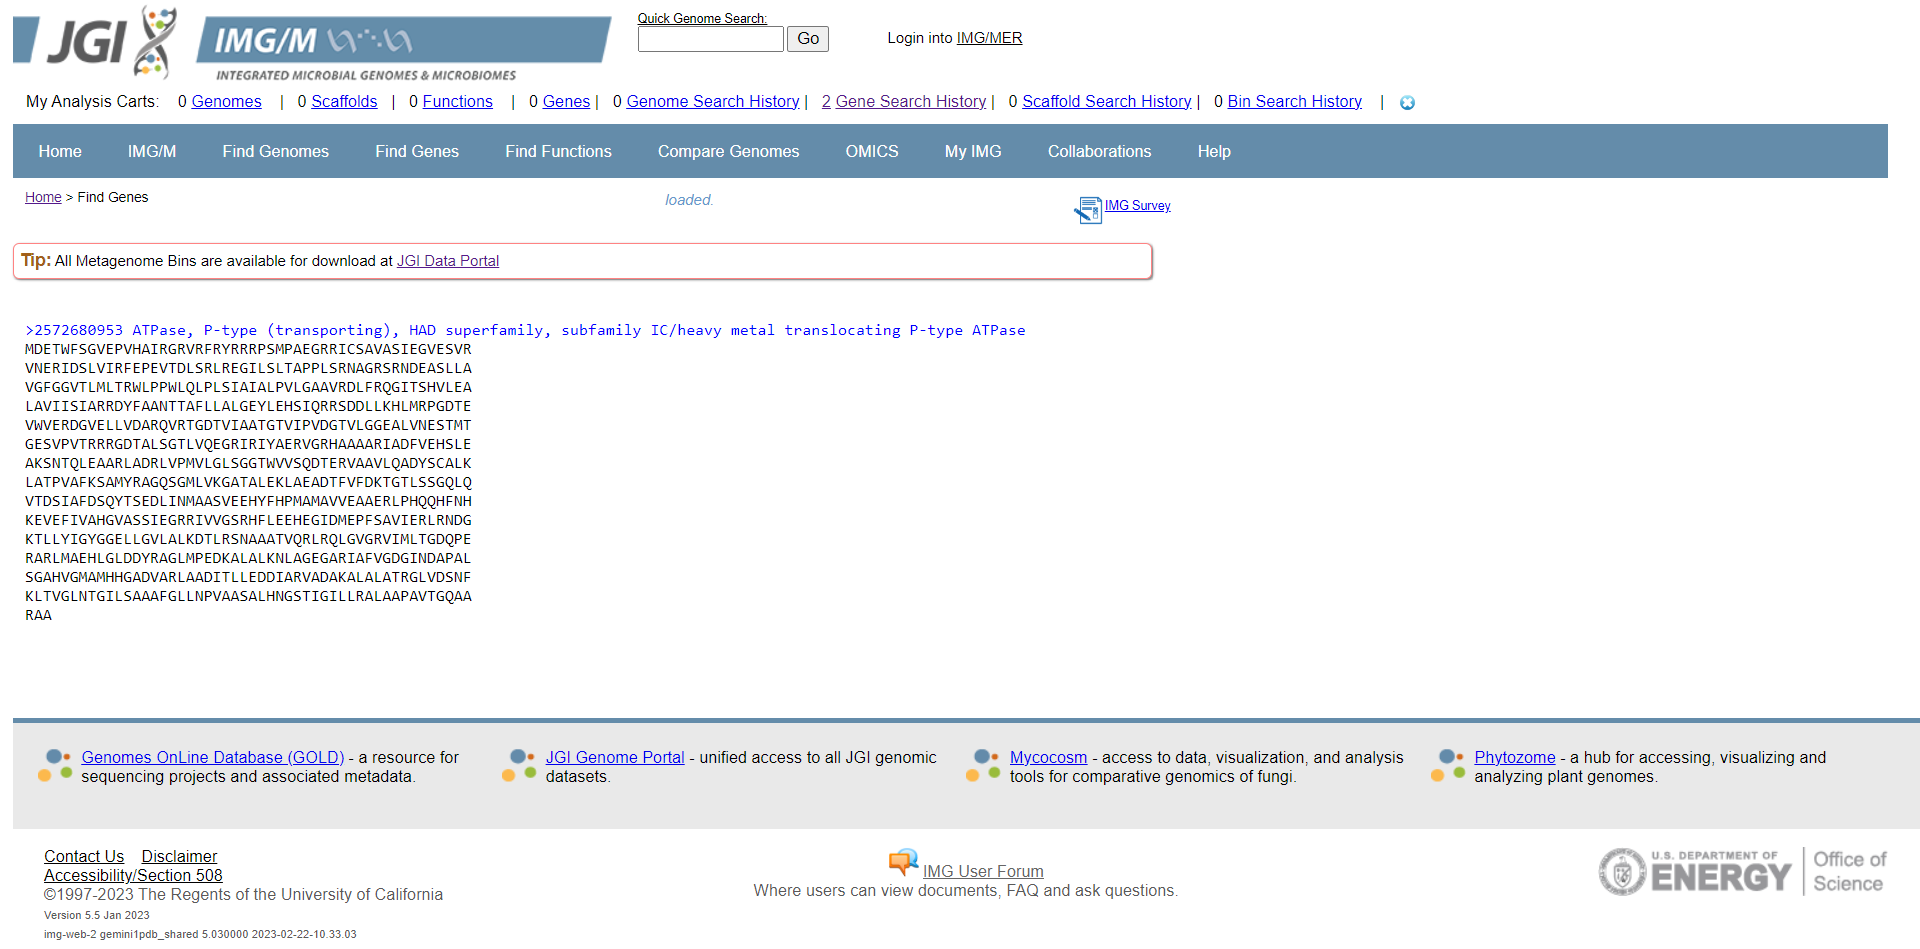

We want to extract the text that correspond to the protein sequence

In [ ]:
# retrive the text from the url
url = "https://img.jgi.doe.gov/cgi-bin/m/main.cgi?section=GeneDetail&page=genePageMainFaa&gene_oid=2572680953"
html_page = requests.get(url).text

# parse the html content and filter only the text
soup = BeautifulSoup(html_page, "html.parser")
text = soup.get_text()
text

'\n\n\nIMG\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n#myAutoComplete {\n    width:25em; /* set width here or else widget will expand to fit its container */\n    padding-bottom:2em;\n}\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  window.dataLayer = window.dataLayer || [];\n  function gtag(){dataLayer.push(arguments);}\n  gtag(\'js\', new Date());\n\n  gtag(\'config\', \'G-1J2T521DFJ\');\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n Quick Genome Search: \n\n\n\n\n\n\n\n\n  var url = "https://img.jgi.doe.gov/api/autocompleteAll_json.php";\n  $("document").ready(function() {\n  $("#autocomplete").autocomplete({\n  source: url,\n  autoFocus: true\n  });\n  });\n\n\n  .ui-menu-item {\n  font-size: 12px;\n  }\n  .ui-autocomplete {\n  max-height: 300px;\n  overflow-y: auto;\n  overflow-x: hidden;\n  }\n\n\n\n\n\n\n \n  Login into IMG/MER\n\n\n\n\n\nfunction ConfirmDelete()\n{\n  var x = confirm("Are you sure you want to DELETE ALL analysis cart\'s items?");\n  if (x) {\n      //alert("do delete now - TODO")

The data that we need to retrive is between 2 patterns

1. \n\n\n\n\n\n\n>
2. \n\n\n \n\n \n\n\n\n\n\n\n\n\n

In [ ]:
# set the patterns
filter1 = "\n\n\n\n\n\n\n>"
filter2 = "\n\n\n \n\n \n\n\n\n\n\n\n\n\n"

# apply it to the text
protein = text.split(filter1)[1].split(filter2)[0]
protein

'2572680953 ATPase, P-type (transporting), HAD superfamily, subfamily IC/heavy metal translocating P-type ATPase\nMDETWFSGVEPVHAIRGRVRFRYRRRPSMPAEGRRICSAVASIEGVESVR\nVNERIDSLVIRFEPEVTDLSRLREGILSLTAPPLSRNAGRSRNDEASLLA\nVGFGGVTLMLTRWLPPWLQLPLSIAIALPVLGAAVRDLFRQGITSHVLEA\nLAVIISIARRDYFAANTTAFLLALGEYLEHSIQRRSDDLLKHLMRPGDTE\nVWVERDGVELLVDARQVRTGDTVIAATGTVIPVDGTVLGGEALVNESTMT\nGESVPVTRRRGDTALSGTLVQEGRIRIYAERVGRHAAAARIADFVEHSLE\nAKSNTQLEAARLADRLVPMVLGLSGGTWVVSQDTERVAAVLQADYSCALK\nLATPVAFKSAMYRAGQSGMLVKGATALEKLAEADTFVFDKTGTLSSGQLQ\nVTDSIAFDSQYTSEDLINMAASVEEHYFHPMAMAVVEAAERLPHQQHFNH\nKEVEFIVAHGVASSIEGRRIVVGSRHFLEEHEGIDMEPFSAVIERLRNDG\nKTLLYIGYGGELLGVLALKDTLRSNAAATVQRLRQLGVGRVIMLTGDQPE\nRARLMAEHLGLDDYRAGLMPEDKALALKNLAGEGARIAFVGDGINDAPAL\nSGAHVGMAMHHGADVARLAADITLLEDDIARVADAKALALATRGLVDSNF\nKLTVGLNTGILSAAAFGLLNPVAASALHNGSTIGILLRALAAPAVTGQAA\nRAA'

In [ ]:
# split the protein by line breaks
protein = protein.split("\n")
protein

['2572680953 ATPase, P-type (transporting), HAD superfamily, subfamily IC/heavy metal translocating P-type ATPase',
 'MDETWFSGVEPVHAIRGRVRFRYRRRPSMPAEGRRICSAVASIEGVESVR',
 'VNERIDSLVIRFEPEVTDLSRLREGILSLTAPPLSRNAGRSRNDEASLLA',
 'VGFGGVTLMLTRWLPPWLQLPLSIAIALPVLGAAVRDLFRQGITSHVLEA',
 'LAVIISIARRDYFAANTTAFLLALGEYLEHSIQRRSDDLLKHLMRPGDTE',
 'VWVERDGVELLVDARQVRTGDTVIAATGTVIPVDGTVLGGEALVNESTMT',
 'GESVPVTRRRGDTALSGTLVQEGRIRIYAERVGRHAAAARIADFVEHSLE',
 'AKSNTQLEAARLADRLVPMVLGLSGGTWVVSQDTERVAAVLQADYSCALK',
 'LATPVAFKSAMYRAGQSGMLVKGATALEKLAEADTFVFDKTGTLSSGQLQ',
 'VTDSIAFDSQYTSEDLINMAASVEEHYFHPMAMAVVEAAERLPHQQHFNH',
 'KEVEFIVAHGVASSIEGRRIVVGSRHFLEEHEGIDMEPFSAVIERLRNDG',
 'KTLLYIGYGGELLGVLALKDTLRSNAAATVQRLRQLGVGRVIMLTGDQPE',
 'RARLMAEHLGLDDYRAGLMPEDKALALKNLAGEGARIAFVGDGINDAPAL',
 'SGAHVGMAMHHGADVARLAADITLLEDDIARVADAKALALATRGLVDSNF',
 'KLTVGLNTGILSAAAFGLLNPVAASALHNGSTIGILLRALAAPAVTGQAA',
 'RAA']

In [ ]:
# retrive the info of the header
header = protein[0]
header

'2572680953 ATPase, P-type (transporting), HAD superfamily, subfamily IC/heavy metal translocating P-type ATPase'

In [ ]:
# retrive the info of sequence
seq = "".join(protein[1:])
seq

'MDETWFSGVEPVHAIRGRVRFRYRRRPSMPAEGRRICSAVASIEGVESVRVNERIDSLVIRFEPEVTDLSRLREGILSLTAPPLSRNAGRSRNDEASLLAVGFGGVTLMLTRWLPPWLQLPLSIAIALPVLGAAVRDLFRQGITSHVLEALAVIISIARRDYFAANTTAFLLALGEYLEHSIQRRSDDLLKHLMRPGDTEVWVERDGVELLVDARQVRTGDTVIAATGTVIPVDGTVLGGEALVNESTMTGESVPVTRRRGDTALSGTLVQEGRIRIYAERVGRHAAAARIADFVEHSLEAKSNTQLEAARLADRLVPMVLGLSGGTWVVSQDTERVAAVLQADYSCALKLATPVAFKSAMYRAGQSGMLVKGATALEKLAEADTFVFDKTGTLSSGQLQVTDSIAFDSQYTSEDLINMAASVEEHYFHPMAMAVVEAAERLPHQQHFNHKEVEFIVAHGVASSIEGRRIVVGSRHFLEEHEGIDMEPFSAVIERLRNDGKTLLYIGYGGELLGVLALKDTLRSNAAATVQRLRQLGVGRVIMLTGDQPERARLMAEHLGLDDYRAGLMPEDKALALKNLAGEGARIAFVGDGINDAPALSGAHVGMAMHHGADVARLAADITLLEDDIARVADAKALALATRGLVDSNFKLTVGLNTGILSAAAFGLLNPVAASALHNGSTIGILLRALAAPAVTGQAARAA'

We want to apply this code to all proteins in the dataset.

Note: this code will take time. It is not efficient, and will be recommendable to use the JGI-API, but this is an example of how we can retreive any kind of data from almost all sources as part of the text minning process.

In [ ]:
# create empty list to store data
ids     = []
headers = []
seqs    = []

# extract the data for all proteins
for id in tqdm(df["gene_id"], desc = "Downloading sequences from the DB"):

  # generate the url and retrive the page
  url = "https://img.jgi.doe.gov/cgi-bin/m/main.cgi?section=GeneDetail&page=genePageMainFaa&gene_oid=" + str(id)
  html_page = requests.get(url).text

  # if we find info, scrape it
  try:
      # parse the html content and filter only the text
      soup = BeautifulSoup(html_page, "html.parser")
      text = soup.get_text()

      # set the patterns
      # filter1 = "\n\n\n\n\n\n\n>"
      # filter2 = "\n\n\n \n\n \n\n\n\n\n\n\n\n\n"

      # apply it to the text
      protein = text.split(filter1)[1].split(filter2)[0]
      protein = protein.split("\n")

      # create the data that we need
      header = protein[0]
      seq = "".join(protein[1:])

      # save it
      ids.append(id)
      headers.append(header)
      seqs.append(seq)

  # otherwise, print the gene_id without info
  except:
      print(f"No information was found for gene id: {id}")

      continue

No information was found for gene id: 2579568498


No information was found for gene id: 2630015713


No information was found for gene id: 2566143464


In [ ]:
# create a df with the data
df_seqs = pd.DataFrame()
df_seqs["gene_id"] = ids
df_seqs["header"] = headers
df_seqs["seq"] = seqs
df_seqs

gene_id                                             header  \
0     637124597  637124597 heavy metal translocating P-type ATPase   
1     637456760          637456760 METAL TRANSPORTING ATPASE MTA72   
2     637475465  637475465 putative cation transport ATPase, po...   
3     637607529         637607529 putative cation transport ATPase   
4     637781355  637781355 Heavy metal translocating P-type ATPase   
..          ...                                                ...   
625  2738928484              2738928484 Cd2+/Zn2+-exporting ATPase   
626  2739817910  2739817910 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   
627  2745711085            2745711085 cation-transporting ATPase G   
628  2754359878  2754359878 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   
629  2755618021  2755618021 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   

                                                   seq  
0    MGLGRLLRYLLLRPLLPAPVRMATALLRATPFITQGLRSLARGRLS...  
1    MKPKKASNSELFSLRLEHATSKRVRYSFCYEGGCRPEPMALQIALE...  
2    MTDKRWLSAVEIVHRLPGRIRLRYQRRSKTSDPALLAGIVRLIDGV...  
3    MTSGSWFGTLELAHRTRGRARFRYRCRKGTPTDARTIERAAENIPG...  
4    MNARESSAACGGHCSVAHEIPGRIRLRSRRLYDPELDVAYLQAVVE...  
..                                                 ...  
625  MTTVKLVENVAPGPGGASFLSLMTPERWVEIGRILLTGAVALLYWQ...  
626  MNVAPSNCHEHPHVSQADLARIVLVGLAAMLAWAQPLGIRHHPVLF...  
627  MPSWRDRFDLDLGWRAALCAVAAVIVGLGLVWPDHRVPAIGVICLT...  
628  MSTTTEVIEVNICGMDCADCAAHVQHALAALPGVEHATVLLSAERA...  
629  MTTLAAAAPLCPASAQPCTCFRPFERSCSASAAEQAKRSPGWLGDR...  

[630 rows x 3 columns]

In [ ]:
# This seqs have no info
df[~df.gene_id.isin(df_seqs.gene_id)]

gene_id               phylum   genome_id  \
185  2579568498  Alphaproteobacteria  2576861778   
225  2630015713           Firmicutes  2627854050   
558  2566143464  Alphaproteobacteria  2565956550   

                                   gene_name        locus_tag  \
185             Azospirillum brasilense Az39     ABAZ39_22910   
225            Eubacterium limosum ATCC 8486  Ga0077618_10391   
558  Novosphingobium pentaromativorans US6-1         NSU_4560   

    p1b_atpase_color    TM4_6  TM6_8  R_rich_motif  
185          #E7F4EC  DYSCALK  HNGTT  HRVPGRIRLRYA  
225          #E7F4EC  DYSCAIK  HNFST  HDMPGRIRLRCG  
558          #FFFFFF  AGACGIA  HVASE           NaN

gene_id = 2566143464 as an example

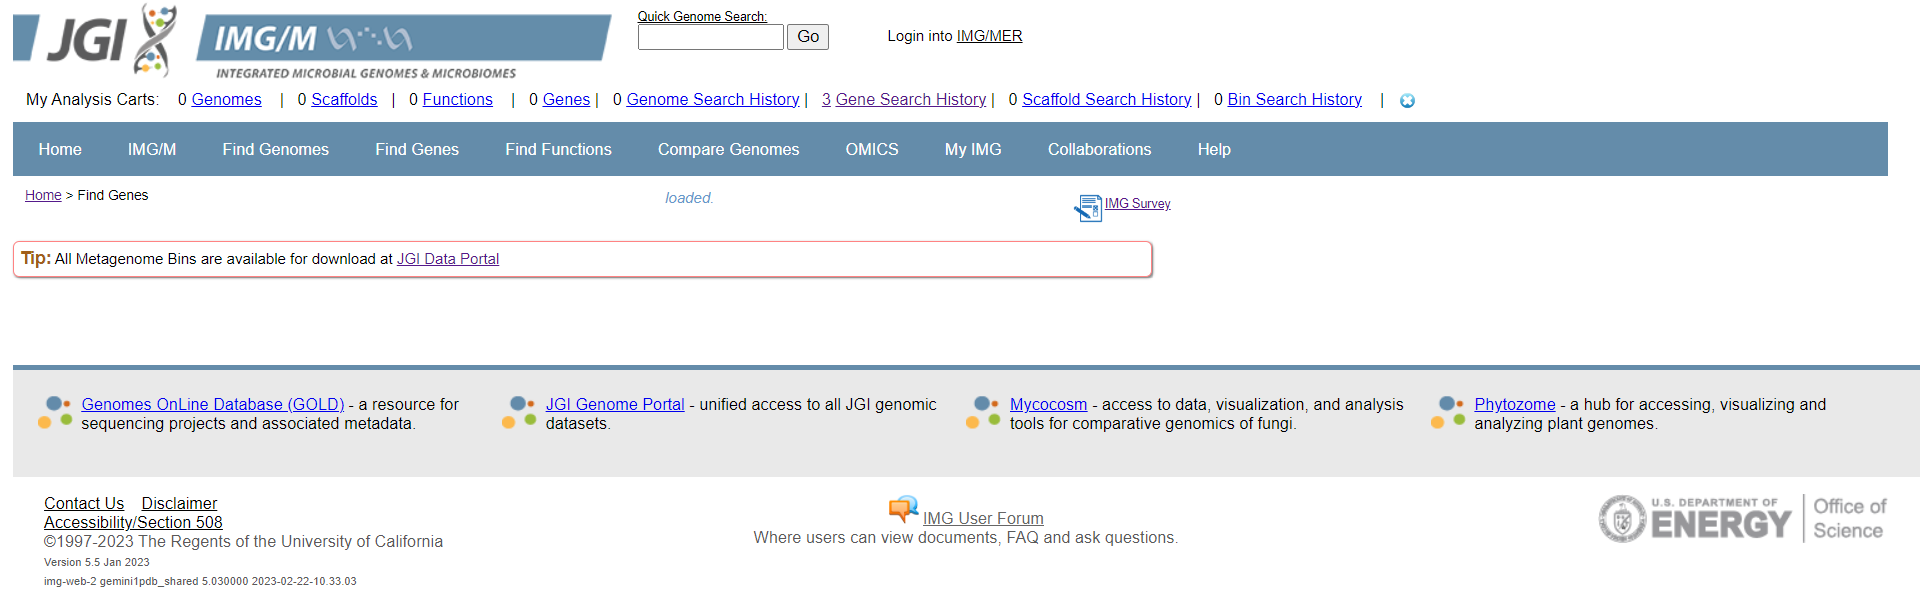

In [ ]:
# merge the data of aa seqs with the main df
df_with_seqs = pd.merge(df, df_seqs, on = "gene_id")
df_with_seqs

gene_id                 phylum   genome_id  \
0     637124597    Deltaproteobacteria   637000096   
1     637456760  Epsilonproteobacteria   637000341   
2     637475465    Alphaproteobacteria   637000239   
3     637607529     Betaproteobacteria   637000012   
4     637781355    Deltaproteobacteria   637000095   
..          ...                    ...         ...   
625  2738928484    Alphaproteobacteria  2738541314   
626  2739817910            Chloroflexi  2739367764   
627  2745711085         Actinobacteria  2744054798   
628  2754359878            Chloroflexi  2751186035   
629  2755618021    Alphaproteobacteria  2754412603   

                                gene_name         locus_tag p1b_atpase_color  \
0    Desulfovibrio vulgaris Hildenborough           DVU3332          #E7F4EC   
1         Wolinella succinogenes DSM 1740            WS1571          #E7F4EC   
2       Rhodopseudomonas palustris CGA009           RPA2333          #E7F4EC   
3             Aromatoleum aromaticum EbN1            ebA609          #E7F4EC   
4            Desulfovibrio alaskensis G20          Dde_0495          #E7F4EC   
..                                    ...               ...              ...   
625       Rhizobium daejeonense DSM 17795   Ga0196644_11272          #FFFFFF   
626         Unclassified Anaerolineae GB5      PROKKA_00789          #FFFFFF   
627         Cutibacterium avidum HL307PV1   Ga0133096_14834          #FFFFFF   
628  Candidatus Chloroploca asiatica B7-9  Ga0213408_105212          #FFFFFF   
629                         Bosea sp. 124    Ga0213554_0932          #FFFFFF   

       TM4_6  TM6_8  R_rich_motif  \
0    DYSCAIR  HNLTT          n/ae   
1    DYSCALK  HNGTT  HATSKRVRYSFC   
2    DYSCALK  HNGTT  HRLPGRIRLRYQ   
3    DYSCALK  HNGST  HRTRGRARFRYR   
4    DYSCAIK  HNAST  HEIPGRIRLRSR   
..       ...    ...           ...   
625  TSPAELG  HLGPD           NaN   
626  AGACGIA  HVASE           NaN   
627  AGACGVA  HVGSE           NaN   
628  ACSCSFA  QSLPD           NaN   
629  AGACGVA  HVSSE           NaN   

                                                header  \
0    637124597 heavy metal translocating P-type ATPase   
1            637456760 METAL TRANSPORTING ATPASE MTA72   
2    637475465 putative cation transport ATPase, po...   
3           637607529 putative cation transport ATPase   
4    637781355 Heavy metal translocating P-type ATPase   
..                                                 ...   
625              2738928484 Cd2+/Zn2+-exporting ATPase   
626  2739817910 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   
627            2745711085 cation-transporting ATPase G   
628  2754359878 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   
629  2755618021 Cd2+/Zn2+-exporting ATPase/Cu+-expo...   

                                                   seq  
0    MGLGRLLRYLLLRPLLPAPVRMATALLRATPFITQGLRSLARGRLS...  
1    MKPKKASNSELFSLRLEHATSKRVRYSFCYEGGCRPEPMALQIALE...  
2    MTDKRWLSAVEIVHRLPGRIRLRYQRRSKTSDPALLAGIVRLIDGV...  
3    MTSGSWFGTLELAHRTRGRARFRYRCRKGTPTDARTIERAAENIPG...  
4    MNARESSAACGGHCSVAHEIPGRIRLRSRRLYDPELDVAYLQAVVE...  
..                                                 ...  
625  MTTVKLVENVAPGPGGASFLSLMTPERWVEIGRILLTGAVALLYWQ...  
626  MNVAPSNCHEHPHVSQADLARIVLVGLAAMLAWAQPLGIRHHPVLF...  
627  MPSWRDRFDLDLGWRAALCAVAAVIVGLGLVWPDHRVPAIGVICLT...  
628  MSTTTEVIEVNICGMDCADCAAHVQHALAALPGVEHATVLLSAERA...  
629  MTTLAAAAPLCPASAQPCTCFRPFERSCSASAAEQAKRSPGWLGDR...  

[630 rows x 11 columns]

In [ ]:
# export the data and upload it to drive for future analysis
df_with_seqs.to_csv("data.csv", index = False)

## Data analysis

In [ ]:
#@markdown  We will need to install conda-colab to install other libraries, it will restart our session on colab.
! pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:42
🔁 Restarting kernel...


In [ ]:
#@markdown Import python libraries. Also, install seqkit, mafft, FastTree.

# install libs
! conda install -y -c bioconda seqkit
! conda install -y -c bioconda fasttree
! conda install -y -c bioconda mafft
! pip install -qqq https://github.com/debbiemarkslab/EVcouplings/archive/develop.zip
! pip install -qqq buddysuite

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from evcouplings.align import Alignment, map_matrix

Solving environment: \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - seqkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    conda-23.1.0               |   py38h578d9bd_0         907 KB  conda-forge
    openssl-3.0.8              |       h0b41bf4_0         2.5 MB  conda-forge
    pluggy-1.0.0               |     pyhd8ed1ab_5          16 KB  conda-forge
    ruamel.yaml-0.17.21        |   py38h0a891b7_2         172 KB  conda-forge
    ruamel.yaml.clib-0.2.7     |   py38h1de0b5d_1         143 KB  conda-forge
    seqkit-2.3.1               |       h9ee0642_0        

In [ ]:
# read data from the github repo https://github.com/miangoar/scratch/tree/main/files
data = pd.read_csv("https://raw.githubusercontent.com/miangoar/scratch/main/files/data.csv")
data.head()

gene_id                 phylum  genome_id  \
0  637124597    Deltaproteobacteria  637000096   
1  637456760  Epsilonproteobacteria  637000341   
2  637475465    Alphaproteobacteria  637000239   
3  637607529     Betaproteobacteria  637000012   
4  637781355    Deltaproteobacteria  637000095   

                              gene_name locus_tag p1b_atpase_color    TM4_6  \
0  Desulfovibrio vulgaris Hildenborough   DVU3332          #E7F4EC  DYSCAIR   
1       Wolinella succinogenes DSM 1740    WS1571          #E7F4EC  DYSCALK   
2     Rhodopseudomonas palustris CGA009   RPA2333          #E7F4EC  DYSCALK   
3           Aromatoleum aromaticum EbN1    ebA609          #E7F4EC  DYSCALK   
4          Desulfovibrio alaskensis G20  Dde_0495          #E7F4EC  DYSCAIK   

   TM6_8  R_rich_motif                                             header  \
0  HNLTT          n/ae  637124597 heavy metal translocating P-type ATPase   
1  HNGTT  HATSKRVRYSFC          637456760 METAL TRANSPORTING ATPASE MTA72   
2  HNGTT  HRLPGRIRLRYQ  637475465 putative cation transport ATPase, po...   
3  HNGST  HRTRGRARFRYR         637607529 putative cation transport ATPase   
4  HNAST  HEIPGRIRLRSR  637781355 Heavy metal translocating P-type ATPase   

                                                 seq  
0  MGLGRLLRYLLLRPLLPAPVRMATALLRATPFITQGLRSLARGRLS...  
1  MKPKKASNSELFSLRLEHATSKRVRYSFCYEGGCRPEPMALQIALE...  
2  MTDKRWLSAVEIVHRLPGRIRLRYQRRSKTSDPALLAGIVRLIDGV...  
3  MTSGSWFGTLELAHRTRGRARFRYRCRKGTPTDARTIERAAENIPG...  
4  MNARESSAACGGHCSVAHEIPGRIRLRSRRLYDPELDVAYLQAVVE...

In [ ]:
# create the iTOL_annot_file to color the tree
# https://itol.embl.de/help.cgi#ranges

# create a df with the color info based in the keywords of iTOL
annot = pd.DataFrame()
annot["gene_id"] = data.gene_id
annot["type"] = "range"
annot["color"] = data.p1b_atpase_color
annot["label"] = "normal"
annot["width"] = 2

# export it
annot.to_csv("iTOL_annot_color.txt", index = False, header = False)

# insert the keywords according to the colors_styles_template
! sed -i "1 i\TREE_COLORS\nSEPARATOR COMMA\n\nDATA" iTOL_annot_color.txt
! head iTOL_annot_color.txt

TREE_COLORS
SEPARATOR COMMA

DATA
637124597,range,#E7F4EC,normal,2
637456760,range,#E7F4EC,normal,2
637475465,range,#E7F4EC,normal,2
637607529,range,#E7F4EC,normal,2
637781355,range,#E7F4EC,normal,2
637781358,range,#E7F4EC,normal,2


In [ ]:
# create the iTOL_annot_file to map the motif
# create a new column called "color" with the binary colors to map the "R_rich_motif" column
data.loc[data["R_rich_motif"].isnull(), "motif_color"] = "#FFFFFF" # white
data.loc[data["R_rich_motif"].notnull(), "motif_color"] = "#000000" # black

# export it
data[["gene_id","motif_color"]].to_csv("iTOL_annot_motif.txt", index = False, header = False)

# insert the keywords according to the dataset_color_strip_template.txt
# https://itol.embl.de/help.cgi#strip
! sed -i "1 i\DATASET_COLORSTRIP\nSEPARATOR COMMA\n\nDATASET_LABEL,RMotif\nLEGEND_TITLE,R rich motif\nLEGEND_SHAPES,1,1\nLEGEND_LABELS,Yes,No\nLEGEND_COLORS,#000000,#FFFFFF\n\nDATA" iTOL_annot_motif.txt
! head -n 15 iTOL_annot_motif.txt

DATASET_COLORSTRIP
SEPARATOR COMMA

DATASET_LABEL,RMotif
LEGEND_TITLE,R rich motif
LEGEND_SHAPES,1,1
LEGEND_LABELS,Yes,No
LEGEND_COLORS,#000000,#FFFFFF

DATA
637124597,#000000
637456760,#000000
637475465,#000000
637607529,#000000
637781355,#000000


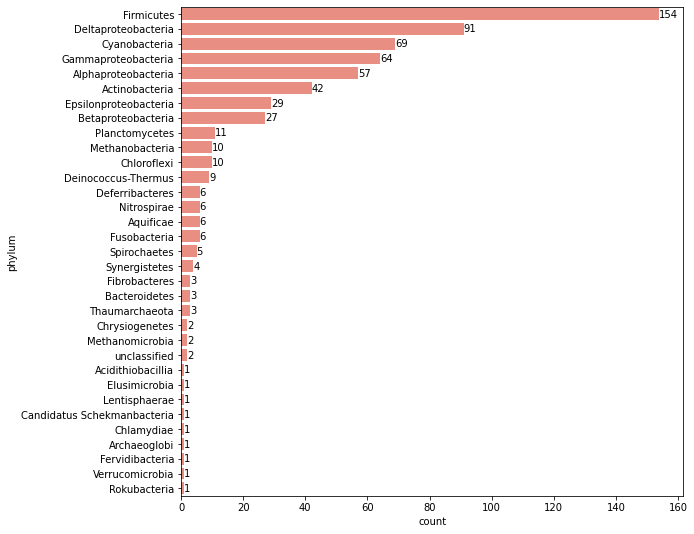

In [ ]:
# create the iTOL_annot_file to map the phyla
# check the most frecuent phyla
plt.figure(figsize=(9,9))
ax = sns.countplot(data = data, y = "phylum", order = pd.value_counts(data.phylum).index, color = "salmon")
ax.bar_label(ax.containers[0]);

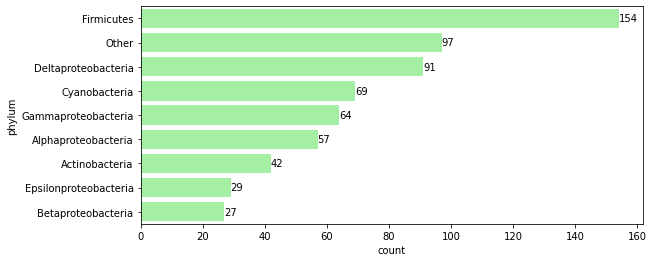

In [ ]:
# take the top 8
top8 = ["Firmicutes", "Deltaproteobacteria", "Cyanobacteria", "Gammaproteobacteria", "Alphaproteobacteria",
        "Actinobacteria", "Epsilonproteobacteria", "Betaproteobacteria"]

# rename all values that have no match in top8 list
data.loc[~data["phylum"].isin(top8), "phylum"] = "Other"

# check it
plt.figure(figsize=(9,4))
ax = sns.countplot(data = data, y = "phylum", order = pd.value_counts(data.phylum).index, color = "palegreen")
ax.bar_label(ax.containers[0]);

In [ ]:
# create a dict to map colors in the df
colors = {
    "Firmicutes":"#4c7cb0", # blue
    "Other":"#d9d7d7", # grey
    "Deltaproteobacteria":"#02e9f5", # cyan
    "Cyanobacteria":"#fafa02", # yellow not found
    "Gammaproteobacteria":"#8a51b5", # purple
    "Alphaproteobacteria":"#911f4c", # vino
    "Actinobacteria":"#f0bdd1", # salmon
    "Epsilonproteobacteria":"#a88d4c", # brown
    "Betaproteobacteria":"#ed83f2" # violet
}

data["phylum_color"] = data["phylum"].map(colors)

# export it
data[["gene_id","phylum_color"]].to_csv("iTOL_annot_phylum.txt", index = False, header = False)

# insert the keywords according to the dataset_color_strip_template.txt
# https://itol.embl.de/help.cgi#strip


! sed -i "1 i\LEGEND_COLORS,#4c7cb0,#d9d7d7,#02e9f5,#fafa02,#8a51b5,#911f4c,#f0bdd1,#a88d4c,#ed83f2\n\nDATA" iTOL_annot_phylum.txt
! sed -i "1 i\LEGEND_LABELS,Firmicutes,Other,Deltaproteobacteria,Cyanobacteria,Gammaproteobacteria,Alphaproteobacteria,Actinobacteria,Epsilonproteobacteria,Betaproteobacteria" iTOL_annot_phylum.txt
! sed -i "1 i\LEGEND_SHAPES,1,1,1,1,1,1,1,1,1" iTOL_annot_phylum.txt
! sed -i "1 i\LEGEND_TITLE,Group" iTOL_annot_phylum.txt
! sed -i "1 i\DATASET_LABEL,Phylum" iTOL_annot_phylum.txt
! sed -i "1 i\SEPARATOR COMMA\n" iTOL_annot_phylum.txt
! sed -i "1 i\DATASET_COLORSTRIP" iTOL_annot_phylum.txt

! head -n 15 iTOL_annot_phylum.txt

DATASET_COLORSTRIP
SEPARATOR COMMA

DATASET_LABEL,Phylum
LEGEND_TITLE,Group
LEGEND_SHAPES,1,1,1,1,1,1,1,1,1
LEGEND_LABELS,Firmicutes,Other,Deltaproteobacteria,Cyanobacteria,Gammaproteobacteria,Alphaproteobacteria,Actinobacteria,Epsilonproteobacteria,Betaproteobacteria
LEGEND_COLORS,#4c7cb0,#d9d7d7,#02e9f5,#fafa02,#8a51b5,#911f4c,#f0bdd1,#a88d4c,#ed83f2

DATA
637124597,#02e9f5
637456760,#a88d4c
637475465,#911f4c
637607529,#ed83f2
637781355,#02e9f5


In [ ]:
# create the iTOL_annot_file to change the labels https://itol.embl.de/help.cgi#labels
data["header"] = data["header"].replace

data[["gene_id","gene_name"]].to_csv("iTOL_annot_label.txt", index = False, header = False)
! sed -i "1 i\LABELS\nSEPARATOR COMMA\n\nDATA" iTOL_annot_label.txt
! head iTOL_annot_label.txt

LABELS
SEPARATOR COMMA

DATA
637124597,Desulfovibrio vulgaris Hildenborough
637456760,Wolinella succinogenes DSM 1740
637475465,Rhodopseudomonas palustris CGA009
637607529,Aromatoleum aromaticum EbN1
637781355,Desulfovibrio alaskensis G20
637781358,Desulfovibrio alaskensis G20


In [ ]:
# export data
data[["gene_id", "seq"]].to_csv("data.csv",index = False, header = False, sep = "\t")

# convert table to fasta
! seqkit tab2fx data.csv > data.fasta

# check it
! head -n28 data.fasta

>637124597
MGLGRLLRYLLLRPLLPAPVRMATALLRATPFITQGLRSLARGRLSVDVLDAAAIGVSLL
RRDFRSVGTITFLLAVGEALEAWTRKASREGLAASLALDVDTIWVRRGEAEVQVPLASLA
DGDVVVVRAGGAIPVDGVVVDGEALVNQASMTGEPLGVMRVAGAAVFAGTVVEEGTLGIR
ATGVGHETRLSRIVDFIERSEALKAGIQGKAERLADAVVPFSFALAASVWLLTRDPARAA
SVLLVDYSCAIRLATPLAILSAMREGASRGVLVKGGRFLEGLAAADAVVFDKTGTLTEAR
PRVTAVIPAEGFERDDVLRIAACLEEHFPHPVARAVVHKAEEQHLQHHEEHAEVEYVVAH
GIASRLHGERVLVGSHHFVHEDEGVPVSTMDEAVATLSAQGHSVLYLAIGGRLAGVLGIE
DPLRPEAPAVVTALRQSGVRRILMLTGDGERTAAAVAARLGIDEYRAQVLPADKAFVVQE
LKAQGHTVIMVGDGINDAPALSSADVGVTLRDGTDLAREVADVVLLHCDLTDLAVARELG
RRTLARIRHGFISTMTLNTLFLAAGLAGLARPGVAAVLHNLTTVGVALNAMRPLLPAMER
AGGDTA
>637456760
MKPKKASNSELFSLRLEHATSKRVRYSFCYEGGCRPEPMALQIALESLEGIKSARVNPAL
NNLILEHEGREPKEMESAIKGVLERVSLRGKACASKDSCLVLREEIPSSGGVVRAGTSLL
LEPFLKNPNAKLGAAAIGSTPIVWDGIKDLFEHGLTSKVLEAMAVAISIYRQDFRAANSA
SFMLALGEYIEEATVYKSDDLIKELSKPQVEEVWIEKHQKGRIETILVPIQEVKSGDIVV
VGAGEIVPVDGHVMSGEAMLNQISMTGEAEPVRKSRGDRVLSGTVVEEGRIKIWAEHVGD
ETTTARIRSYIQSSLEEKSSLQLEASKMADGLVPITLGLAVLSYVVSQDLTRLASV

In [ ]:
# build the msa with a gap open penalty = −6.9 as in the methods of the paper
! mafft --op 6.9 --thread 2 data.fasta > msa.fasta

nthread = 2
nthreadpair = 2
nthreadtb = 2
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -6.90, +0.00, +0.00



Making a distance matrix ..

There are 1 ambiguous characters.
  601 / 630 (thread    1)
done.

Constructing a UPGMA tree (efffree=0) ... 
  620 / 630
done.

Progressive alignment 1/2... 
STEP   443 / 629 (thread    0) f
Reallocating..done. *alloclen = 2984
STEP   601 / 629 (thread    0) f
done.

Making a distance matrix from msa.. 
  600 / 630 (thread    1)
done.

Constructing a UPGMA tree (efffree=1) ... 
  620 / 630
done.

Progressive alignment 2/2... 
STEP   477 / 629 (thread    1) f
Reallocating..done. *alloclen = 2984
STEP   601 / 629 (thread    0) f
done.

disttbfast (aa) Version 7.515
alg=A, model=BLOSUM62, 6.90, -0.00, -0.00, noshift, amax=0.0
2 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft 

In [ ]:
# clean the msa with the option gappyout of trimmal
! alignbuddy msa.fasta -q --trimal gappyout > msa_gappyout.fasta

In [ ]:
# convert the msas to tables to plot them
! seqkit fx2tab -H -Q msa.fasta > msa.csv
! seqkit fx2tab -H -Q msa_gappyout.fasta > msa_gappyout.csv

In [ ]:
def plot_msa(msa):

  """
  info: a function to plot the msa occupancy
  -----------
  input:
    msa = msa as csv
  -----------
  output: plot
  """

  # read the msa and replace gapps as NaNs
  name = msa
  df = pd.read_csv(name, sep = "\t", names=["id", "seq"])
  df = df["seq"].apply(lambda x: pd.Series(list(x)))
  df = df.replace("-", np.nan)

  # plot
  plt.figure(figsize=(12,6))
  plt.imshow(df.isna(), aspect = "auto", interpolation = "nearest", cmap = "gray")
  plt.xlabel("MSA position")
  plt.ylabel("seq")
  plt.title(msa)
  plt.show()

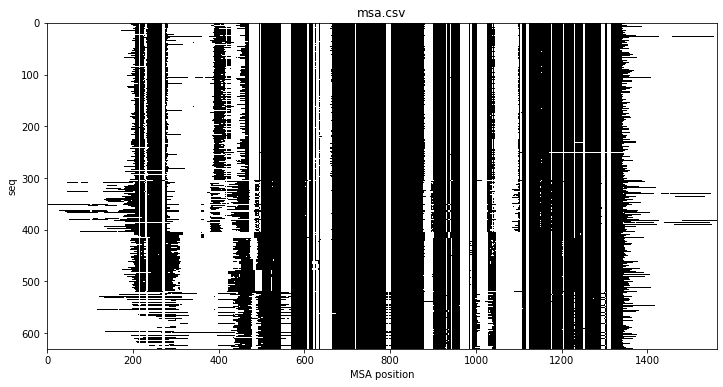

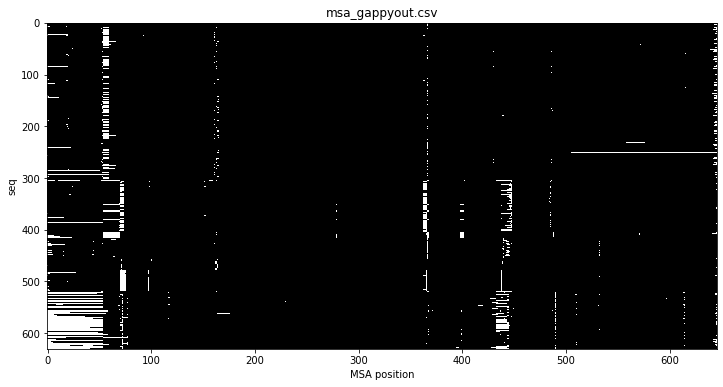

In [ ]:
# run the fx
plot_msa("msa.csv")
plot_msa("msa_gappyout.csv")

In [ ]:
def do_ident_mat(msa):

    """
    plot a identity matrix given a MSA
    """

    # Read in a sequence alignment from a fasta file
    msa_input = msa
    with open(msa_input, "r") as infile:
        aln = Alignment.from_file(infile, format="fasta")

    # Sequence length and number of sequences
    print(f"Alignment is of length {aln.L} and has {aln.N} sequences")

    # calculate the percent identity of every sequence in the alignment to the first sequence
    aln.identities_to(aln.matrix[0])

    identity_matrix = np.zeros((aln.N, aln.N))
    identity_matrix.fill(np.nan)

    #loop through each sequence
    for idx in range(identity_matrix.shape[0]):

        #calculate all the percent identitites to that sequence
        idents = aln.identities_to(aln.matrix[idx,:])
        identity_matrix[idx] = idents

    # plot
    print(f"Minimum sequence identity detected for {msa}: {identity_matrix.min()} \n")
    plt.figure(figsize=(25,22))
    sns.clustermap(identity_matrix, yticklabels=False, xticklabels=False, cmap = "Spectral_r",
                   dendrogram_ratio=(.07, .07), method="ward", metric="euclidean",
                   cbar_pos=(0.3, -0.05, 0.5, 0.03), cbar_kws={"orientation": "horizontal"})
    plt.title("Sequence identity")


Alignment is of length 646 and has 630 sequences
Minimum sequence identity detected for msa_gappyout.fasta: 0.14396284829721362 



/usr/local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1800x1584 with 0 Axes>

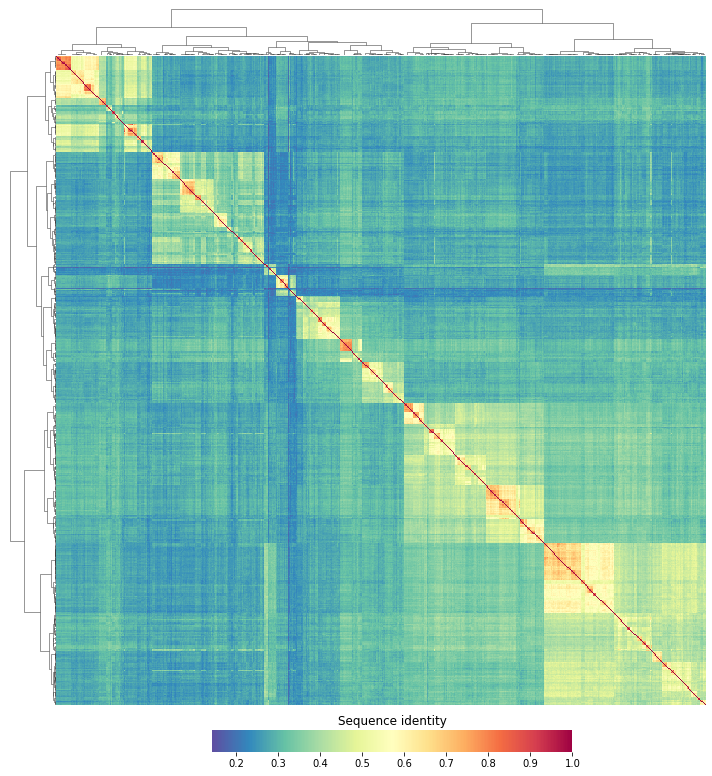

In [ ]:
# run the fx
do_ident_mat("msa_gappyout.fasta")

In [ ]:
# to check the best evo model for the data
# conda install -c bioconda iqtree
#! iqtree -s msa_gappyout.fasta -m MF -T 2

In [ ]:
# build a fast tree with the LG model with fasttree
! fasttree -lg msa.fasta > tree_LG_msa.tree

FastTree Version 2.1.11 Double precision (No SSE3)
Alignment: msa.fasta
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Le-Gascuel 2008, CAT approximation with 20 rate categories
Ignored unknown character X (seen 1 times)
Initial topology in 4.17 seconds
Refining topology: 37 rounds ME-NNIs, 2 rounds ME-SPRs, 19 rounds ML-NNIs
Total branch-length 159.136 after 19.05 sec
ML-NNI round 1: LogLk = -612728.072 NNIs 79 max delta 34.41 Time 60.90
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 1.368 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -573606.241 NNIs 30 max delta 16.47 Time 87.15
ML-NNI round 3: LogLk = -573486.857 NNIs 5 max delta 14.51 Time 94.06
ML-NNI round 4: LogLk =

In [ ]:
# build a fast tree with the LG model with fasttree
! fasttree -lg msa_gappyout.fasta > tree_LG_msa_gappyout.tree

FastTree Version 2.1.11 Double precision (No SSE3)
Alignment: msa_gappyout.fasta
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Le-Gascuel 2008, CAT approximation with 20 rate categories
Ignored unknown character X (seen 1 times)
Initial topology in 2.81 seconds
Refining topology: 37 rounds ME-NNIs, 2 rounds ME-SPRs, 19 rounds ML-NNIs
Total branch-length 140.176 after 25.57 sec
ML-NNI round 1: LogLk = -481177.964 NNIs 86 max delta 19.75 Time 46.34
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 1.202 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -451169.758 NNIs 35 max delta 20.10 Time 64.76
ML-NNI round 3: LogLk = -451100.672 NNIs 5 max delta 13.70 Time 68.23
ML-NNI round 4

In [ ]:
# the use of RaxML or IQtree are limited to the cpu cores of colab
# https://github.com/amkozlov/raxml-ng/wiki/Input-data#evolutionary-model
# ! raxml-ng --all --threads 2 --msa msa_gappyout.fasta --model LG+G+F fast

After editing the tree in iTOL the results looks like:

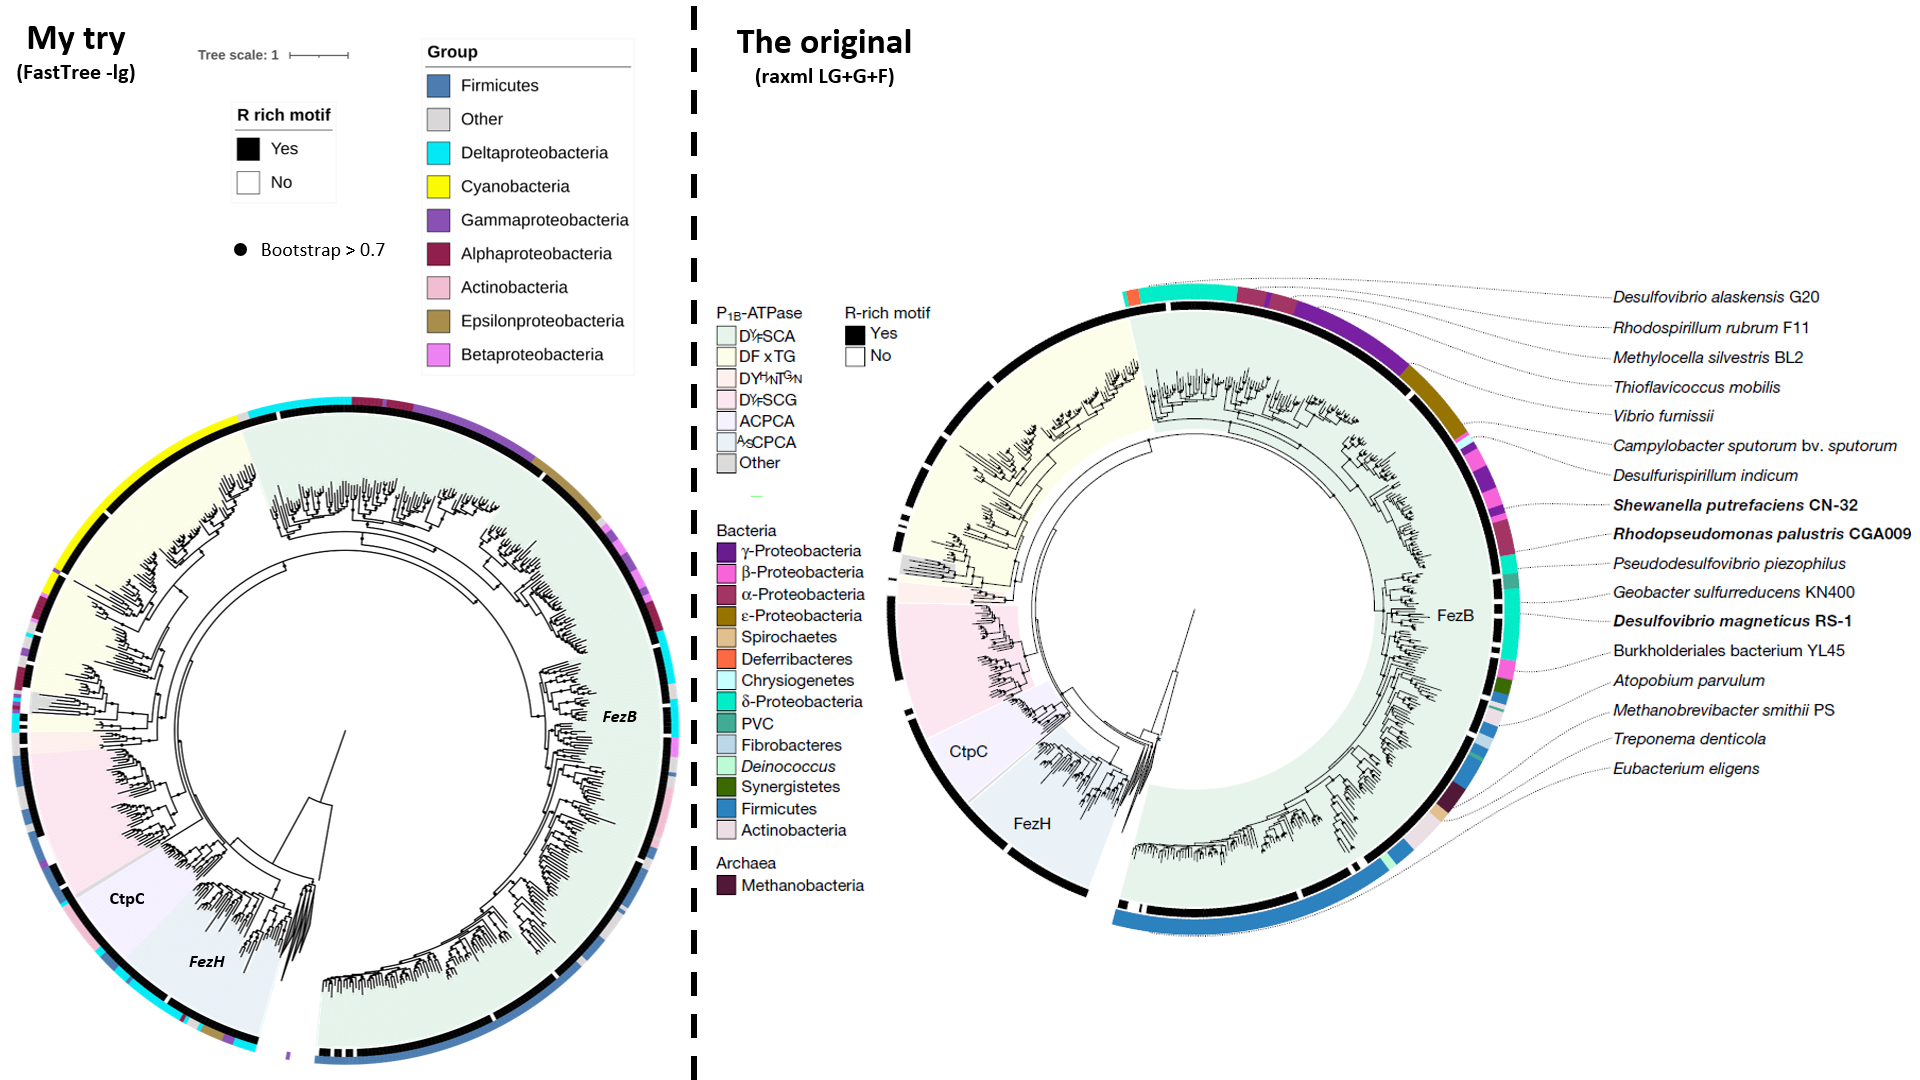

You can find the main dataset with the sequences, the tree, MSAs and the iTOL annotation files in:

https://github.com/miangoar/scratch/tree/main/files

And the interactive tree in:

https://itol.embl.de/tree/18921618049490131677295417


# Ancestral sequence reconstruction

In this section i take the data from the paper [Origin of complexity in haemoglobin evolution (Nature, 2020)](https://www.nature.com/articles/s41586-020-2292-y), where the authors studied the evolution of the hemoglobins present in the current vertebrates. There are many interesting findings.

The current hemoglobins in vertebrates are heterotetramers composed of two sub-units of alpha-hemoglobins and two sub-units of beta-hemoglobins. The authors find that :
1. the ancestor of alpha are capable to from a cooperative heterotetramer together with the ancestor of beta.
2. the ancestor of alpha AND beta are capable to form a coperative Homotetramer
3. but, the most basal ancestor studied are not capable to form any protein complex, because is a monomeric protein.

The next image attempts to illustrate this using an oversimplification of the evolutionary process (image modified from [Spence et al. 2021](https://www.sciencedirect.com/science/article/abs/pii/S0959440X21000555)).

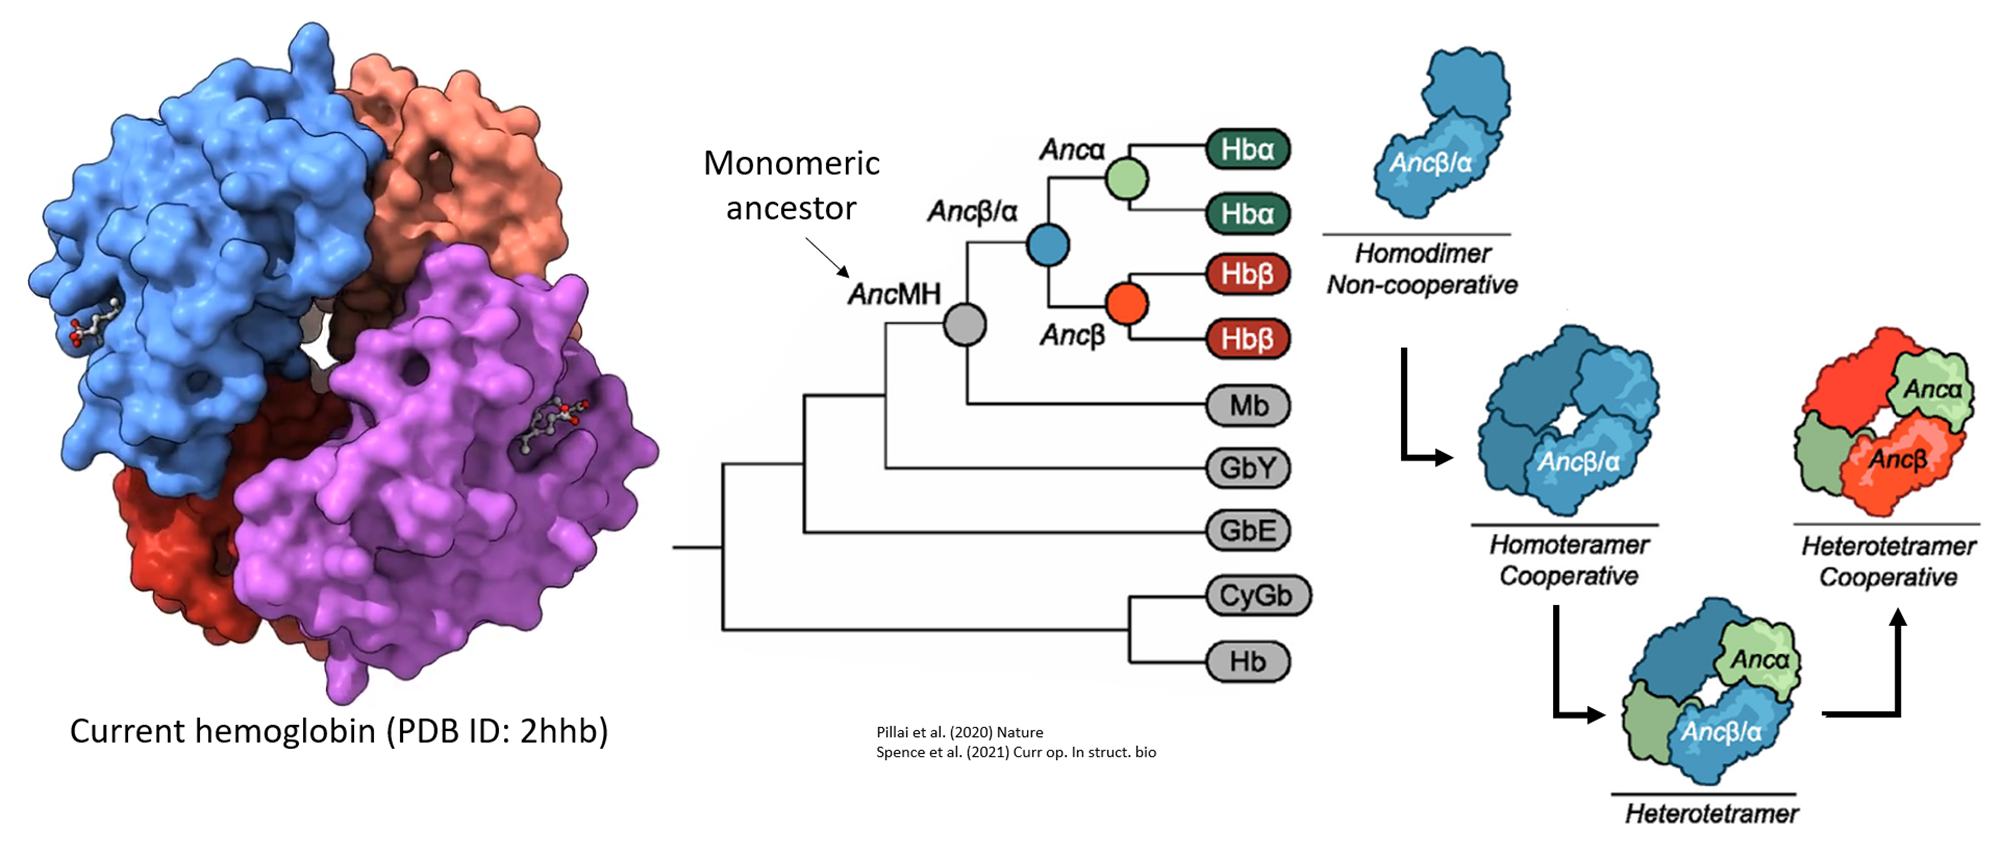

In [ ]:
#@markdown  We will need to install conda-colab to install other libraries, it will restart our session on colab.
! pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [ ]:
#@markdown Import libs. Also, install TimeTree, Seqkit TM-align and biopython


# install libs
! conda install -c bioconda treetime
! conda install -c bioconda seqkit
! conda install -c conda-forge biopython
! conda install -c bioconda tmalign

# import libraries
import pandas as pd
from Bio import Phylo

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - treetime


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.81             |   py38h1de0b5d_0         2.6 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    con

We need to download the original data provided  by the authors:
- https://datadryad.org/stash/dataset/doi:10.5061/dryad.w0vt4b8mx

Only the tree and the MSA are stored in the GitHub repository:
- https://github.com/miangoar/scratch/tree/main/files/hemogobin_data

After load [the tree in iTOL](https://itol.embl.de/tree/189216181113252391677806069), we need to copy the leafs labels of the tree to create a pandas dataframe. Go to the root and and click on the option "Copy leaf labels" and save it in the file "leafs_ids.txt".

In [ ]:
# read it "leafs_ids.txt"
df_leafs = pd.read_csv("https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/leafs_ids.txt", names=["id"])
df_leafs["id"] = df_leafs["id"].str.replace(" ", "_") # by default iTOL translate the underscores as a spaces
df_leafs = df_leafs.sort_values("id").reset_index(drop=True)
df_leafs

id
0    Atlantic_h
1       CYG2_EL
2    CYGB1_DANR
3    CYGB_CHICK
4    CYGB_COELA
..          ...
172    aHb6_PET
173    aHb_Lflu
174    aMb1_PET
175   mouse_Ngb
176  platypus_G

[177 rows x 1 columns]

In [ ]:
# download the MSA
! wget -nv https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/globin_alignment_with_accessioncodes.txt .

2023-03-04 00:19:45 URL:https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/globin_alignment_with_accessioncodes.txt [32401/32401] -> "globin_alignment_with_accessioncodes.txt" [1]
wget: unable to resolve host address ‘.’
FINISHED --2023-03-04 00:19:45--
Total wall clock time: 0.4s
Downloaded: 1 files, 32K in 0.003s (9.68 MB/s)


In [ ]:
# get the headers from the MSA
! seqkit fx2tab -n -i globin_alignment_with_accessioncodes.txt > headers.txt

# read it
df_headers = pd.read_csv("headers.txt", names=["id"])
df_headers = df_headers.sort_values("id").reset_index(drop=True)
df_headers

id
0        Atlantic_h_AAD40480.1
1       CYG2_EL_XP_007883271.1
2          CYGB1_DANR_Q8UUR3.2
3    CYGB_CHICK_NP_001008789.1
4    CYGB_COELA_XP_005993267.1
..                         ...
172        aHb6_PET_BAF47286.1
173          aHb_Lflu_P02207.2
174        aMb1_PET_QFR42345.1
175      mouse_Ngb_NP_071859.1
176  platypus_G_XP_028904557.1

[177 rows x 1 columns]

[TimeTree](https://treetime.readthedocs.io/en/latest/commands.html#ancestral) can easily generate ancestral sequences using a set of heuristics. It is faster than others tools od ASR like PAML or BEAST at the cost of sensitivity and flexibility (like FastTrre)


Available evolutionary models: https://treetime.readthedocs.io/en/latest/gtr.html?#treetime.GTR.standard

By default, Timetree need to have the same IDs in the tree and the MSA, and this is not the case as you see in the dataframes. For that, we need to create a iTOL_annotation_file to rename the labels based on the original labels in the leafs.



In [ ]:
# concat dfs and export it to manually check
df_concat = pd.concat([df_headers,df_leafs], axis = 1)
df_concat.to_csv("df_concat.csv", index = False)

I detected the following errors whose correspondence is wrong

| pair1 | pair2 | renamed as|
|-|-|-|
| MYG_SHARK2_P14397.2| MYG_SHARK|MYG_SHARK2 |
|MYG_SHARK_P02206.2 |MYG_SHARK2 |MYG_SHARK |
| HBB_ORCA_XP_004270431.1| HBB_ORCA2| HBB_ORCA|
| HBB_ORCA2_XP_004279312.1 | HBB_ORCA |HBB_ORCA2  |




In [ ]:
# read the curated dataset
df_curated = pd.read_csv("https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/df_concat_curated.csv")

In [ ]:
# download the original tree
! wget -nv https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/globin_phylogeny_constrained_ALRT.tre

2023-03-04 00:20:27 URL:https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/globin_phylogeny_constrained_ALRT.tre [7456/7456] -> "globin_phylogeny_constrained_ALRT.tre" [1]


In [ ]:
# create a list with the original names and the new names
new_names      = df_curated["id"].to_list()
original_names = df_curated["id.1"].to_list()

# read the tree
tree = Phylo.read("globin_phylogeny_constrained_ALRT.tre", "newick")

# create a mapping dict
name_dict = dict(zip(original_names, new_names))

# rename the leafs
for leaf in tree.get_terminals():
    leaf.name = name_dict.get(leaf.name, leaf.name)

# save the renamed tree
Phylo.write(tree, "globin_phylogeny_constrained_ALRT_renamed.tre", "newick")

1

In [ ]:
# run timetree
! treetime ancestral --aln globin_alignment_with_accessioncodes.txt --tree globin_phylogeny_constrained_ALRT_renamed.tre --outdir ancestral_hemo --aa --reconstruct-tip-states # --gtr JTT92


0.00	-TreeAnc: set-up

Inferred sequence evolution model (saved as ancestral_hemo//sequence_evolution_model.txt):
Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.0636
  C: 0.0293
  D: 0.0514
  E: 0.0459
  F: 0.0618
  G: 0.0451
  H: 0.0523
  I: 0.0428
  K: 0.0548
  L: 0.0855
  M: 0.041
  N: 0.0441
  P: 0.0336
  Q: 0.0439
  R: 0.0433
  S: 0.0561
  T: 0.0526
  V: 0.0573
  W: 0.0254
  Y: 0.042
  *: 0.0178
  -: 0.0104

Symmetrized rates from j->i (W_ij):
	A	C	D	E	F	G	H	I	K	L	M	N	P	Q	R	S	T	V	W	Y	*	-
  A	0	1.0695	1.354	2.2396	0.2345	3.1961	0.5993	1.0006	1.5849	0.6979	0.6206	0.9479	2.2994	1.0726	0.7566	4.2475	2.862	2.0707	0.4167	0.3082	0.5105	0.4801
  C	1.0695	0	0.813	0.6914	0.6456	0.9867	0.7231	0.8618	0.6211	0.6073	0.7885	1.0635	0.6962	0.7089	1.0724	1.2843	1.3145	1.0054	0.9838	1.0974	1.1411	0.54
  D	1.354	0.813	0	6.1288	0.2444	1.7788	0.618	0.3387	0.9835	0.2316	0.3456	3.3968	0.8249	1.1418	0.6088	1.1831	0.8103	0.3895	0.5017	0.4292	0.7152	0.3734
  E	2.2396	0.6914	6.1288	0	0.

In [ ]:
# add a prefix
! cd ancestral_hemo && rename "s/^/ancestral_hemo_/" *

# zip and download the data
! zip -r ancestral_hemo.zip ancestral_hemo

  adding: ancestral_hemo/ (stored 0%)
  adding: ancestral_hemo/ancestral_hemo_ancestral_sequences.fasta (deflated 76%)
  adding: ancestral_hemo/ancestral_hemo_branch_mutations.txt (deflated 13%)
  adding: ancestral_hemo/ancestral_hemo_sequence_evolution_model.txt (deflated 63%)
  adding: ancestral_hemo/ancestral_hemo_annotated_tree.nexus (deflated 59%)



By default, TimeTree generate a tree in nexus format, we need a newick format to use in iTOL. To convert from nexus to newick we can use the [phylolab webserber](https://bioinformatics.phylolab.net/form/tree-format-conversion). With the tree in newick we can vizualize the our phylogeny and the nodes are renamed. This nodes are availabe as fasta sequences in the file "ancestral_sequences.fasta" that TimeTree generates. Arbitrarily, i selected the follows ancestral nodes and two current proteins.

Also, you can inspect [the tree](https://itol.embl.de/tree/18921618111387481677890276)

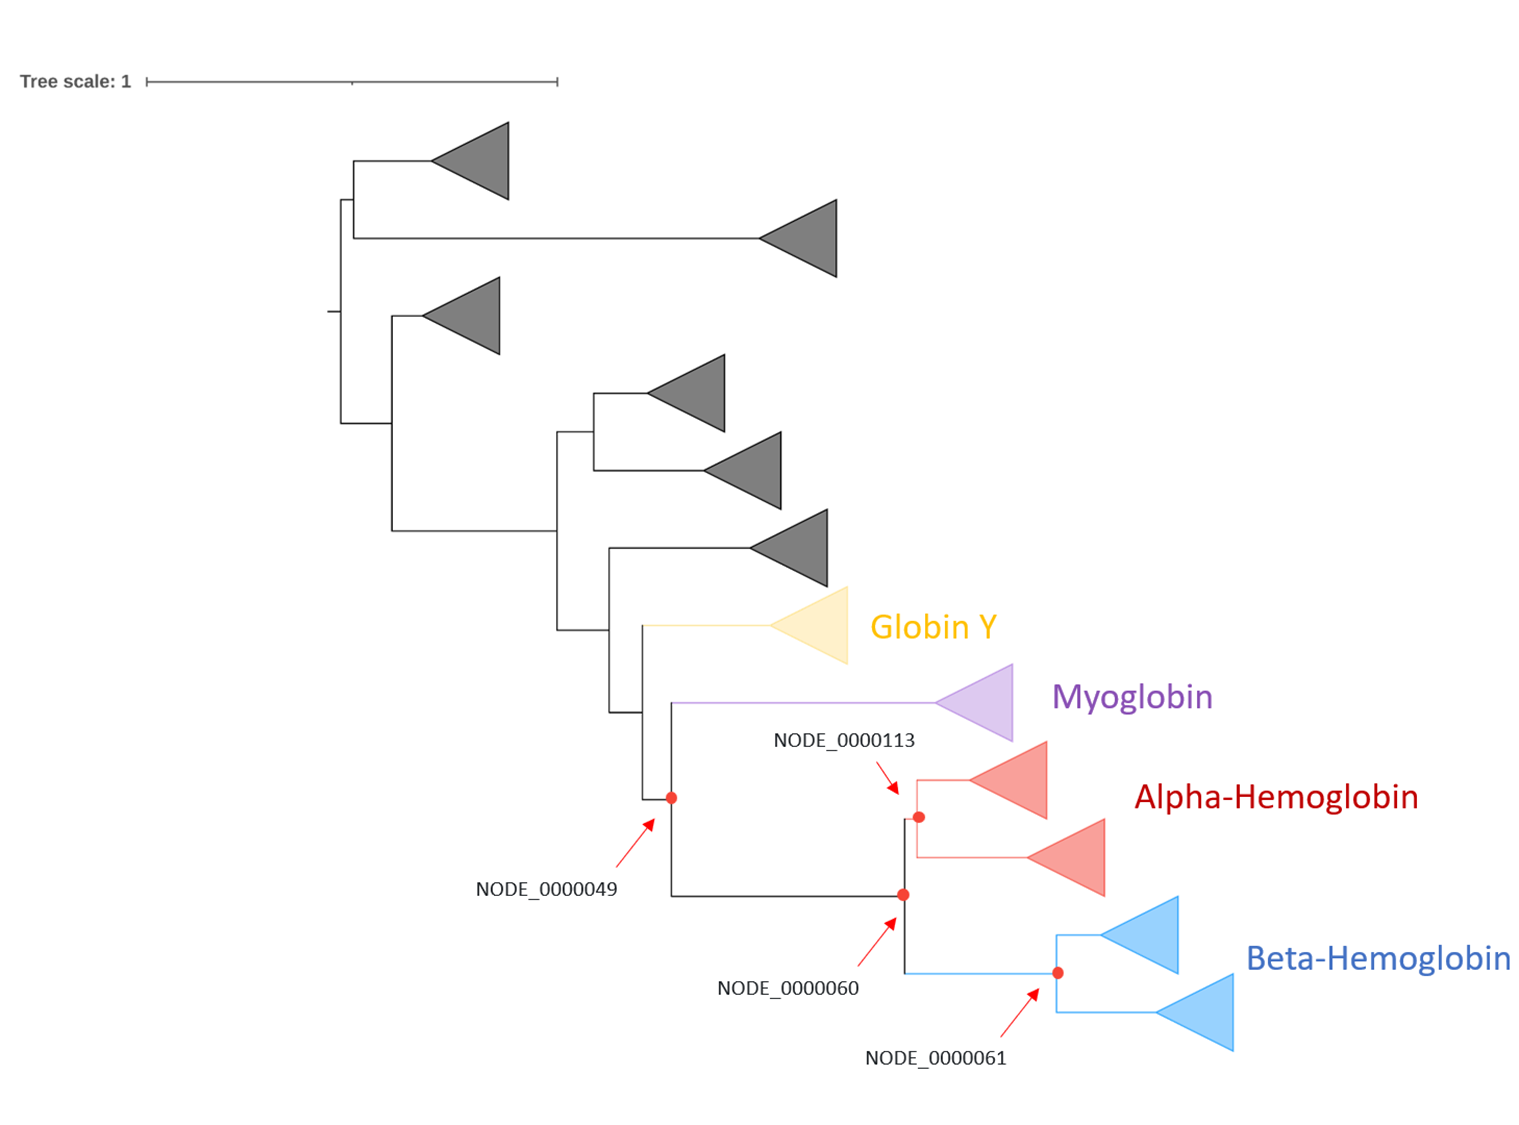

In [ ]:
! wget -nv https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/selected_nodes_IDs.txt

2023-03-04 00:58:20 URL:https://raw.githubusercontent.com/miangoar/scratch/main/files/hemogobin_data/selected_nodes_IDs.txt [54/54] -> "selected_nodes_IDs.txt" [1]


In [ ]:
! cat selected_nodes_IDs.txt

NODE_0000049
NODE_0000113
NODE_0000060
NODE_0000061

In [ ]:
# retrive the seqs from the output of TimeTree witout gaps
! seqkit grep -f selected_nodes_IDs.txt ancestral_hemo/ancestral_hemo_ancestral_sequences.fasta | seqkit seq -g > selected_nodes.fasta
! cat selected_nodes.fasta

[INFO] 4 patterns loaded from file
>NODE_0000049
MLSEADKEAIRDIWGKVYANAEENGTTILIRMFTEHPETKQYFSKFKDISTEEMKGSPQV
RAHGKRVMGAIGDVVQNLDNLASILKPLAEKHATKHKVDPKNFKLLSNVILKVLAEKFGG
DFTPEARAAWEKLLGVICSELESKYK
>NODE_0000060
MVLSAADKQAIKAIWGKVNAEEIGAEALARMFIVYPQTKTYFSKFSDLSAGSPQVKAHGK
KVMGAIGEAVKHLDNLASALKKLSEKHATKLRVDPVNFKLLSDCILVVLAVHLGADFTPE
VHAAWDKFLAVVASELSEKYR
>NODE_0000061
MVHWTAEEKQAITSVWGKVDVEEVGAEALARMFVVYPWTKRYFSKFGDLSAGNPKVKAHG
KKVMGALGEAVKHLDNIKAAFKKLSEKHSEKLHVDPENFKLLGDCLIVVLAAHLGADFTP
EVQAAWDKFLAVVVSALSRKYH
>NODE_0000113
MVLSAADKQAIKAIWGKVNAEEIGAEALARMFIVYPQTKTYFSKFSDLSAGSPQVKAHGK
KVMGAIGEAVKHLDNLASALKKLSEKHATKLRVDPVNFKLLSDCILVVLAVHLGADFTPE
VHAAWDKFLAVVASELSEKYR


We can use [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) in order to use AlphaFold2-Multimer to check it this sequences are capable to form a protein complex.

All protein complex predictions are available at:
- https://github.com/miangoar/scratch/tree/main/files/hemogobin_data/af2_predictions


After visualizing them in ChimeraX, we get the next result:

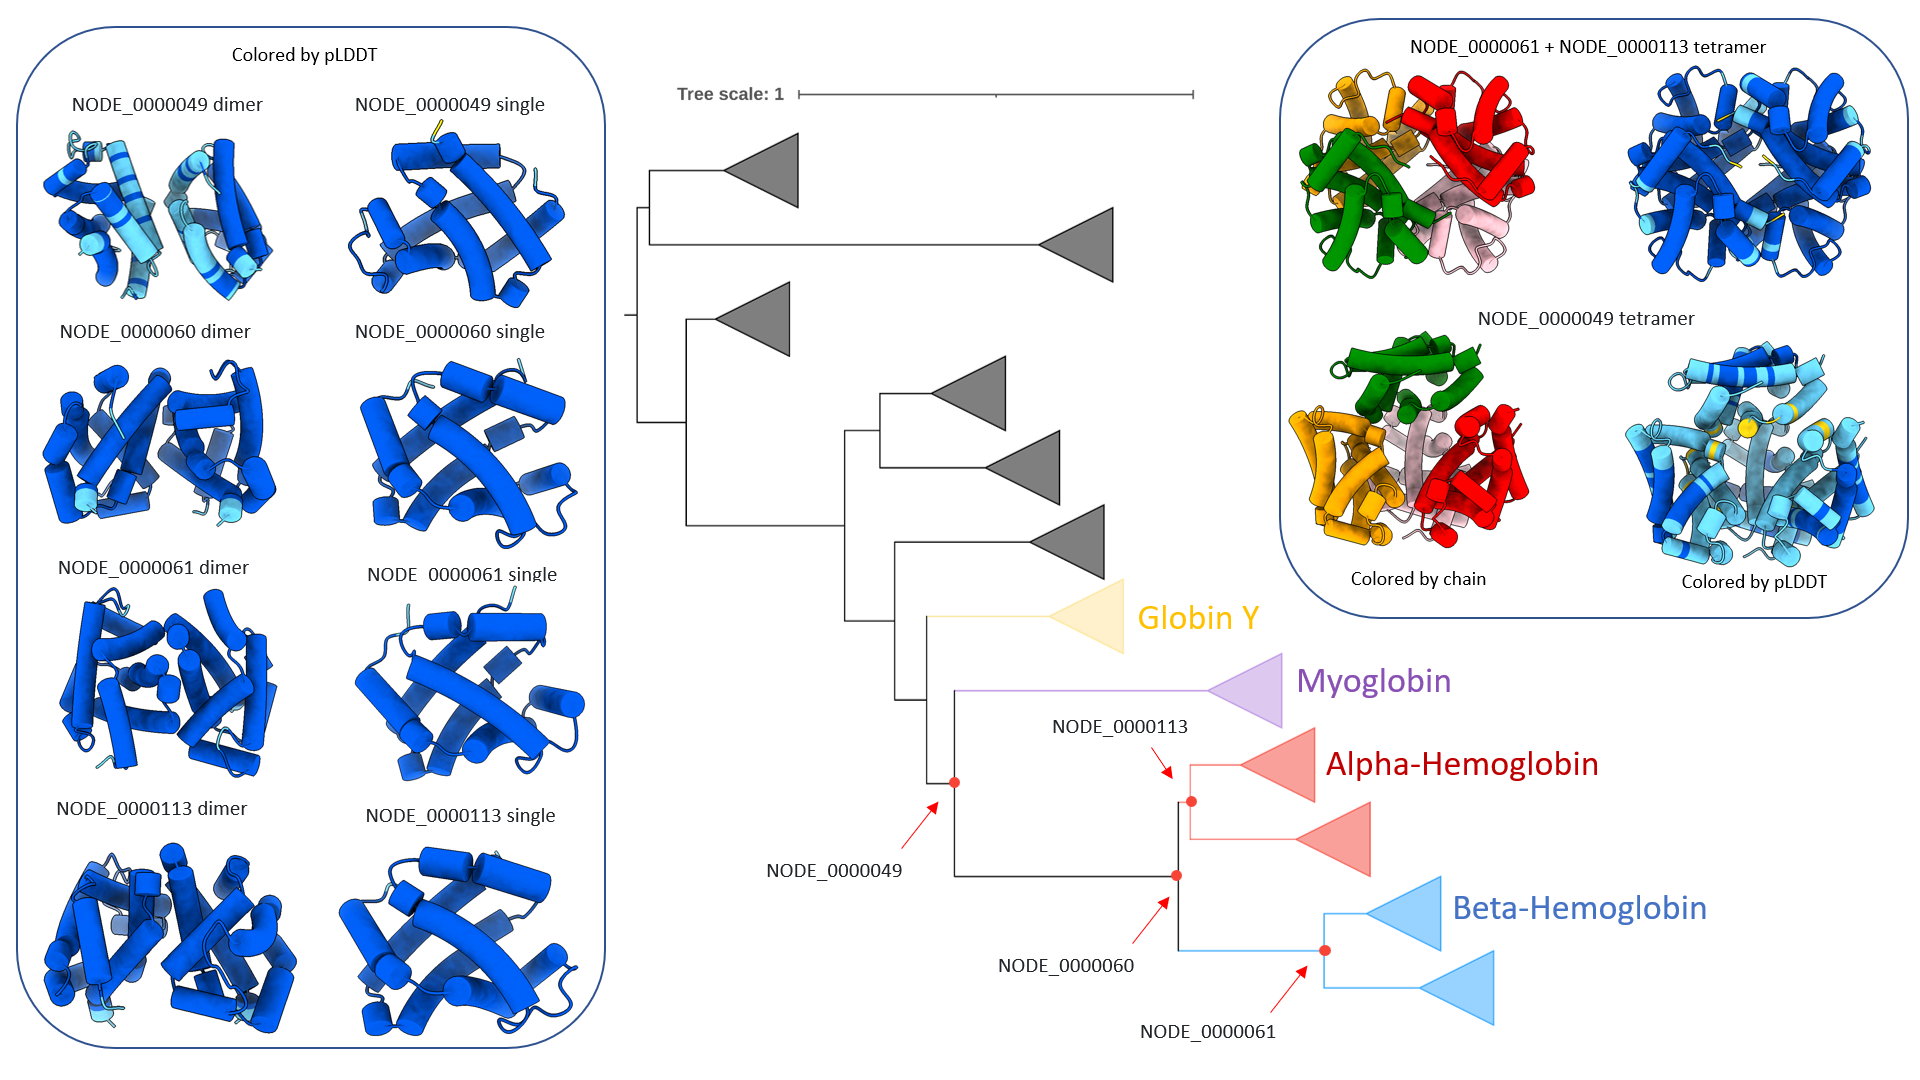